In [1]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import accuracy_score

import numpy as np
import matplotlib.pyplot as plt

from cv_svm import SVM_smooth

In [2]:
X, y = load_breast_cancer(return_X_y=True)
n = X.shape[0]
p = X.shape[1]
y[np.where(y == 0)] = -1

In [3]:
X = StandardScaler().fit_transform(X)
print(X.shape)

(569, 30)


In [4]:
clf = SVC(kernel='linear')
clf.fit(X, y)
sk_coef = clf.coef_/np.linalg.norm(clf.coef_)
print(clf.coef_)
print(clf.intercept_)

[[-0.32157975 -0.0963414  -0.29618472 -0.27044914  0.0145657   0.61925944
  -0.75749079 -0.90968508 -0.07847361  0.34800574 -0.84095245  0.30550603
  -0.23541953 -0.89135374 -0.35509455  0.39115374  0.37739417 -0.46041889
   0.10093298  0.88583541 -0.59013908 -0.97190388 -0.33349947 -0.71227359
  -0.42708268  0.1721726  -1.03818882 -0.09378355 -0.44679874 -0.85526809]]
[0.04438971]


In [5]:
y_pred = clf.predict(X)
accuracy_score(y, y_pred)

0.9876977152899824

In [6]:
clf = SVM_smooth(sigma=2e-2, lbd=1)
clf.fit(X, y, thresh=1e-3, n_iter=2000, eta=0.3/n, approx_cv=True, log_iacv=True, log_iter=True)
print(f"grad {np.linalg.norm(clf.nabla_fgd_(X, y, clf.weights_, clf.sigma_, clf.lbd_))}")
coef = clf.weights_/np.linalg.norm(clf.weights_)
print(f"diff {np.mean(np.abs(coef - sk_coef))} | pct {np.mean(np.abs(coef - sk_coef))/np.sum(np.abs(coef))}")

y_pred = clf.predict(X)
accuracy_score(y, y_pred)

iter 0 | grad 2.8244530663035556
IACV: 2.0377035088121578e-19 | baseline: 0.001486554585145266
iter 1 | grad 2.8228744244941684
IACV: 7.849680240962431e-07 | baseline: 0.0014831201274806234
iter 2 | grad 2.8212345729006634
IACV: 2.354247950394033e-06 | baseline: 0.0014796637968840889
iter 3 | grad 2.8194487661225414
IACV: 4.706698597741898e-06 | baseline: 0.001476141690246388
iter 4 | grad 2.8171879403121816
IACV: 7.838532588556063e-06 | baseline: 0.0014723837489409996
iter 5 | grad 2.811588256438195
IACV: 1.1702948715292013e-05 | baseline: 0.0014669274358627441
iter 6 | grad 2.3814077999407868
IACV: 2.1937892581200273e-05 | baseline: 0.0012418169640021955
iter 7 | grad 1.9854738018811886
IACV: 2.5957865962602077e-05 | baseline: 0.001034575868495928
iter 8 | grad 1.7719558611121962
IACV: 2.9979712247202022e-05 | baseline: 0.000921049487961846
iter 9 | grad 1.6738513501881482
IACV: 3.458537983012842e-05 | baseline: 0.0008680799923203263
iter 10 | grad 1.591062790524251
IACV: 4.052448304

0.8804920913884007

In [7]:
iacv_coef = normalize(clf.loo_iacv_, axis=1)
true_coef = normalize(clf.loo_true_, axis=1)
print(np.mean(np.linalg.norm(iacv_coef - true_coef, 2, axis=1)))
print(np.mean(np.linalg.norm(coef - true_coef, 2, axis=1)))

0.3878112354419436
0.2794508850754837


In [8]:
print(iacv_coef)
print(true_coef)

[[-0.07069488 -0.22481918 -0.06316574 ... -0.02133855 -0.08555647
  -0.15007985]
 [-0.04381218 -0.18405388 -0.04758097 ... -0.06267711 -0.16567394
  -0.15182497]
 [-0.05709731 -0.16154149 -0.05576464 ... -0.03263621 -0.13251292
  -0.19024938]
 ...
 [-0.08564687 -0.10134214 -0.0851349  ... -0.08871587 -0.19809705
  -0.18148111]
 [-0.04758919 -0.1064772  -0.04091364 ... -0.02380026 -0.11830353
  -0.15561118]
 [-0.04509237 -0.21082165 -0.04320967 ... -0.0398783  -0.17209396
  -0.18121747]]
[[-0.04754993 -0.06024228 -0.04694948 ... -0.0457943  -0.10517788
  -0.13687113]
 [-0.06337776 -0.09370028 -0.06165719 ... -0.0567613  -0.09466324
  -0.1290201 ]
 [-0.05870336 -0.09622488 -0.05745003 ... -0.05475594 -0.1041442
  -0.11904625]
 ...
 [-0.06082949 -0.12543815 -0.05970346 ... -0.05577339 -0.08665954
  -0.11676465]
 [-0.0490139  -0.10008644 -0.04820273 ... -0.04576486 -0.09450977
  -0.14499594]
 [-0.05963551 -0.0802261  -0.05835017 ... -0.05469366 -0.09212752
  -0.13238791]]


In [9]:
print(np.std(clf.loo_iacv_))
print(np.std(clf.loo_true_))

0.007768497345729835
0.008637239449703567


In [10]:
print(np.mean(clf.loo_iacv_, axis=0))
print(np.mean(clf.loo_true_, axis=0))

[-0.00395624 -0.00730452 -0.00385891 -0.00410462 -0.00769102 -0.00486798
 -0.00412262 -0.00359591 -0.0078976   0.01306603 -0.00529708  0.0084507
 -0.00536054 -0.00542499  0.02488985 -0.00807725 -0.00836944 -0.0070386
  0.00663768 -0.01883096 -0.00363107 -0.00672161 -0.00357547 -0.00391234
 -0.00701778 -0.00494465 -0.0044002  -0.00348197 -0.00701285 -0.00816422]
[-0.00296235 -0.0050386  -0.00291151 -0.00303875 -0.00583255 -0.00356501
 -0.00308423 -0.00281351 -0.0063483   0.00806647 -0.0037327   0.0052174
 -0.00380252 -0.00386628  0.02798221 -0.00723261 -0.00835744 -0.00512128
  0.00409795 -0.02897874 -0.0028142  -0.00458217 -0.00278702 -0.00294654
 -0.0049588  -0.00358696 -0.00324064 -0.00274789 -0.00502897 -0.00650263]


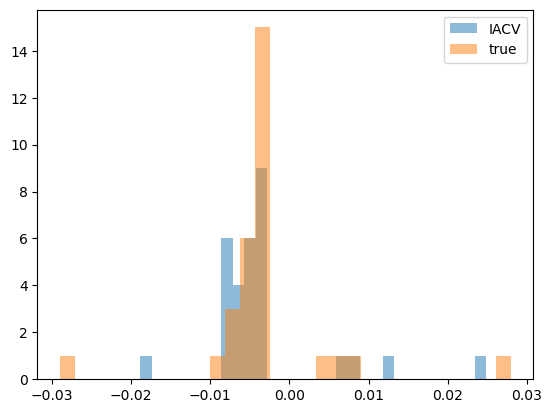

In [11]:
plt.hist(np.mean(clf.loo_iacv_, axis=0), alpha=0.5, bins=30, label="IACV")
plt.hist(np.mean(clf.loo_true_, axis=0), alpha=0.5, bins=30, label="true")
plt.legend()

In [12]:
clf.loo_iacv_

array([[-0.0037694 , -0.01198719, -0.00336795, ..., -0.00113776,
        -0.00456181, -0.00800215],
       [-0.00203286, -0.00854   , -0.00220773, ..., -0.00290818,
        -0.00768718, -0.0070446 ],
       [-0.00268773, -0.00760421, -0.002625  , ..., -0.00153628,
        -0.00623776, -0.00895558],
       ...,
       [-0.00388062, -0.00459177, -0.00385743, ..., -0.00401968,
        -0.00897569, -0.00822283],
       [-0.00251479, -0.00562666, -0.00216203, ..., -0.0012577 ,
        -0.00625161, -0.00822309],
       [-0.00215664, -0.01008302, -0.0020666 , ..., -0.00190727,
        -0.00823078, -0.00866713]])

In [13]:
clf.loo_true_

array([[-0.00300809, -0.00381103, -0.0029701 , ..., -0.00289703,
        -0.00665373, -0.0086587 ],
       [-0.00310092, -0.00458453, -0.00301674, ..., -0.0027772 ,
        -0.00463165, -0.00631265],
       [-0.00306875, -0.00503021, -0.00300323, ..., -0.0028624 ,
        -0.00544419, -0.00622321],
       ...,
       [-0.0029599 , -0.00610369, -0.00290511, ..., -0.00271388,
        -0.00421676, -0.00568165],
       [-0.00310203, -0.00633435, -0.00305069, ..., -0.0028964 ,
        -0.00598141, -0.00917661],
       [-0.00309814, -0.00416785, -0.00303137, ..., -0.00284141,
        -0.00478615, -0.00687773]])

In [14]:
iacv_mean = np.mean(clf.loo_iacv_, axis=0)
coef = iacv_mean/np.linalg.norm(iacv_mean)
print(f"diff {np.mean(np.abs(coef - sk_coef))} | pct {np.mean(np.abs(coef - sk_coef))/np.sum(np.abs(coef))}")

diff 0.16338026385358193 | pct 0.03548922133817423


In [15]:
true_cv_mean = np.mean(clf.loo_true_, axis=0)
coef = true_cv_mean/np.linalg.norm(true_cv_mean)
print(f"diff {np.mean(np.abs(coef - sk_coef))} | pct {np.mean(np.abs(coef - sk_coef))/np.sum(np.abs(coef))}")

diff 0.16945430776364973 | pct 0.04433191257965563


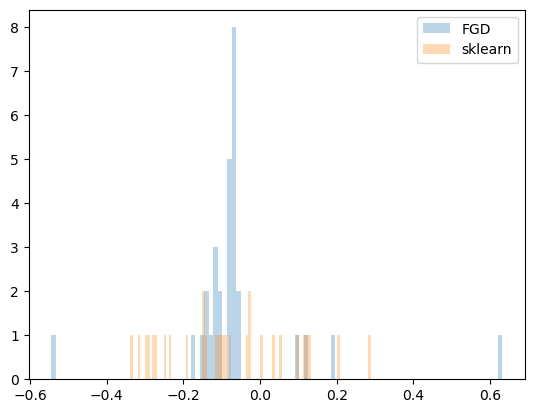

In [16]:
coef = clf.weights_/np.linalg.norm(clf.weights_)
nbin = 100
plt.hist(coef, bins=nbin, label="FGD", alpha=0.3)
plt.hist(sk_coef.flatten(), bins=nbin, label="sklearn", alpha=0.3)
plt.legend()
plt.show()

In [21]:
# test different sigma values
#sigmas = [2e-30, 2e-25, 2e-15, 2e-10, 2e-5, 2e-1]
sigmas = [2e-10, 2e-5, 2e-1, 5e-1, 1, 1.25]
for s in sigmas:
    if s == 0:
        continue
    clf = SVM_smooth(sigma=s, lbd=1e-5)
    #clf.fit(X, y, thresh=5e-3, n_iter=1000, eta=0.5 * s, cv=False, approx_cv=True, log_iacv=False, log_iter=True)
    print("next experiment")
    clf.fit(X, y, thresh=1e-3, n_iter=2000, eta=0.5/n, approx_cv=True, log_iacv=False, log_iter=False)
    y_pred = clf.predict(X)
    score = accuracy_score(y, y_pred)

    coef = clf.weights_/np.linalg.norm(clf.weights_)

    print(clf.weights_)
    print(f"sigma {s} | score {score} | grad {np.linalg.norm(clf.nabla_fgd_(X, y, clf.weights_, clf.sigma_, clf.lbd_))} | sklearn diff {np.mean(np.abs(coef- sk_coef))}")
    print(f"IACV: {np.mean(np.linalg.norm(clf.loo_iacv_ - clf.loo_true_, 2, axis=1))} | baseline: {np.mean(np.linalg.norm(clf.weights_ - clf.loo_true_, 2, axis=1))}" )


next experiment
[-0.00254858 -0.00438575 -0.00273802 -0.0028226  -0.00519573 -0.00334193
 -0.00262675 -0.00260082 -0.00559698  0.01027429 -0.00361296  0.00664539
 -0.00331859 -0.00357033  0.02713742 -0.00639209 -0.00718137 -0.00473517
  0.00521954 -0.02329652 -0.00259751 -0.00435037 -0.00268717 -0.00260287
 -0.00432125 -0.00321626 -0.00309237 -0.00284349 -0.00443642 -0.00564884]
sigma 2e-10 | score 0.8822495606326889 | grad 0.062230500678154714 | sklearn diff 0.1724701809008337
IACV: 23.893552518834532 | baseline: 0.15734348462105807
next experiment
[-0.00263773 -0.00439989 -0.00273306 -0.00311701 -0.00527838 -0.00333469
 -0.00265188 -0.00237691 -0.00564262  0.01027429 -0.00343454  0.00664539
 -0.00332091 -0.00357932  0.0271336  -0.00620941 -0.00725932 -0.00462954
  0.00521954 -0.02333104 -0.00266632 -0.00434561 -0.00284089 -0.00277647
 -0.00433231 -0.00321501 -0.00309524 -0.00286143 -0.00446397 -0.00563682]
sigma 2e-05 | score 0.8822495606326889 | grad 0.04125218779442686 | sklearn di